<a href="https://colab.research.google.com/github/harrisonjansma/2019_Notes/blob/master/DL/Implementations/TensorFlow_Doc_Examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install --upgrade tensorflow

In [1]:
import os
import tensorflow as tf
tf.__version__

'2.1.0'

### Save and Load Models


In [0]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_labels = train_labels[:1000]
test_labels = test_labels[:1000]

train_images = train_images[:1000].reshape(-1, 28 * 28) / 255.0
test_images = test_images[:1000].reshape(-1, 28 * 28) / 255.0

# Define a simple sequential model
def create_model():
  model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(784,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
  ])
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

# Create a basic model instance
model = create_model()


The `tf.keras.callbacks.ModelCheckpoint` callback allows to continually save the model both during and at the end of training.

In [4]:
checkpoint_path = "training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
# Train the model with the new callback
model.fit(train_images, 
          train_labels,  
          epochs=10,
          validation_data=(test_images,test_labels),
          callbacks=[cp_callback])  # Pass callback to training

Train on 1000 samples, validate on 1000 samples
Epoch 1/10
 576/1000 [================>.............] - ETA: 0s - loss: 1.5132 - accuracy: 0.5590 
Epoch 00001: saving model to training/cp.ckpt
1000/1000 [==============================] - 1s 881us/sample - loss: 1.1733 - accuracy: 0.6600 - val_loss: 0.7622 - val_accuracy: 0.7750
Epoch 2/10
 608/1000 [=================>............] - ETA: 0s - loss: 0.4253 - accuracy: 0.8766
Epoch 00002: saving model to training/cp.ckpt
1000/1000 [==============================] - 0s 197us/sample - loss: 0.4275 - accuracy: 0.8730 - val_loss: 0.5715 - val_accuracy: 0.8130
Epoch 3/10
 608/1000 [=================>............] - ETA: 0s - loss: 0.2976 - accuracy: 0.9178
Epoch 00003: saving model to training/cp.ckpt
1000/1000 [==============================] - 0s 196us/sample - loss: 0.2905 - accuracy: 0.9170 - val_loss: 0.4675 - val_accuracy: 0.8480
Epoch 4/10
 544/1000 [===============>..............] - ETA: 0s - loss: 0.2824 - accuracy: 0.9136
Epoch 0000

In [5]:
!ls training/

checkpoint		     cp.ckpt.data-00001-of-00002
cp.ckpt.data-00000-of-00002  cp.ckpt.index


In [6]:
# Create a basic model instance
model = create_model()

# Evaluate the model
loss, acc = model.evaluate(test_images,  test_labels, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100*acc))

1000/1000 - 0s - loss: 2.4016 - accuracy: 0.1280
Untrained model, accuracy: 12.80%


In [7]:
# Loads the weights
model.load_weights(checkpoint_path)

# Re-evaluate the model
loss, acc = model.evaluate(test_images,  test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

1000/1000 - 0s - loss: 0.4193 - accuracy: 0.8580
Restored model, accuracy: 85.80%


Call `model.save` to save the a model's architecture, weights, and training configuration in a single file/folder. This allows you to export a model so it can be used without access to the original Python code*. Since the optimizer-state is recovered, you can resume training from exactly where you left off.

In [0]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model shuold be saved to HDF5.
model.save('my_model.h5') 

### Load Pandas data using `tf.data.Dataset`
Use `tf.data.Dataset.from_tensor_slices` to read the values from a pandas dataframe.

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((df.values, target.values))
train_dataset = dataset.shuffle(len(df)).batch(1)


### Load Image Data


In [0]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [11]:
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

import pathlib
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))

BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])

train_data_gen = img_generator.flow_from_directory(directory=str(data_dir),
                                                   batch_size = BATCH_SIZE,
                                                   shuffle=True,
                                                   target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                   classes = list(CLASS_NAMES))


Found 3670 images belonging to 5 classes.


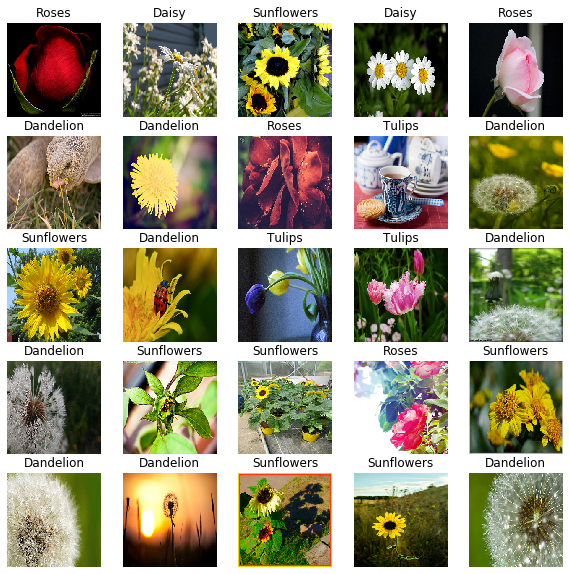

In [12]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

#### Load Images using tf.data
The above `keras.preprocessing` method is convienient, but has three downsides:

- It's slow. See the performance section below.
- It lacks fine-grained control.
- It is not well integrated with the rest of TensorFlow.

To load the files as a `tf.data.Dataset` first create a dataset of the file paths:

In [17]:
!ls {data_dir}

daisy  dandelion  LICENSE.txt  roses  sunflowers  tulips


In [18]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

<ShuffleDataset shapes: (), types: tf.string>

This is a list of filepaths, we need a function that converts a filepath to (image_data, label) pair

In [0]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-2] == CLASS_NAMES

def decode_image(img):
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
  label = get_label(file_path)
  img = tf.io.read_file(file_path)
  img = decode_image(img)
  return (img, label)

labeled_ds = list_ds.map(process_path)

In [23]:
for img, lbl in labeled_ds.take(1):
  print(img.shape)
  print(lbl)

(224, 224, 3)
tf.Tensor([ True False False False False], shape=(5,), dtype=bool)
